## 1. Title & Description
**Lung Nodule Detection EDA**  
This notebook explores the LIDC-IDRI data:  
- Class balance  
- Example CT slices  
- Intensity distributions  

## 2. Imports

In [2]:
# %%
import os
import glob
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
import boto3

from tqdm import tqdm

# Check if 'data' directory exists and list its contents
print("Current directory:", os.getcwd())
print(os.listdir('../data'))

# set plots inline
%matplotlib inline

Current directory: /Users/owenfeng/Documents/DSCollaborativeProject/notebooks
['.DS_Store', 'README.md', 'Patient_Diagnosis']


## 3. Load Annotations & Class Balance

        patientid  diagnosis  \
0  LIDC-IDRI-0068          3   
1  LIDC-IDRI-0071          3   
2  LIDC-IDRI-0072          2   
3  LIDC-IDRI-0088          3   
4  LIDC-IDRI-0090          2   

   Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response  \
0                                                  4                                                                                                                    
1                                                  1                                                                                                                    
2                                                  4                                                                                                                    
3                                                  0                                                                               

<Axes: title={'center': 'Grouped Class Balance'}>

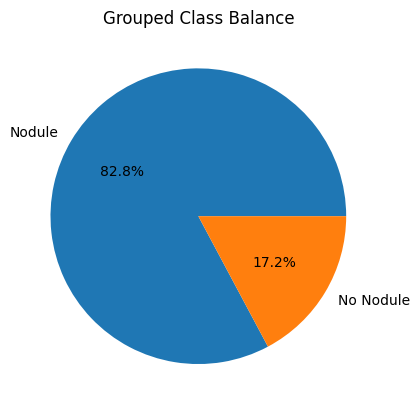

In [27]:
# adjust path if you used a different name
ann = pd.read_excel('../data/Patient_Diagnosis')
ann = ann.rename(columns={
    'Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n': 'diagnosis',
    'TCIA Patient ID': 'patientid'
})
print(ann.head())

# class counts
ann['grouped_label'] = ann['diagnosis'].replace({
    0: 'No Nodule',
    1: 'Nodule',
    2: 'Nodule',
    3: 'Nodule'
})

counts = ann['grouped_label'].value_counts()

counts.plot.pie(autopct='%.1f%%', title='Grouped Class Balance', ylabel='')

## 4. Sample CT Slice Visualization

NEGGAR ['LIDC-IDRI-0068' 'LIDC-IDRI-0071' 'LIDC-IDRI-0072' 'LIDC-IDRI-0088']
PREEM manifest-1748043659198/LIDC-IDRI/LIDC-IDRI-0173
HELLO??
RESPONSEY dict_keys(['ResponseMetadata', 'IsTruncated', 'Name', 'Prefix', 'MaxKeys', 'EncodingType', 'KeyCount'])


TypeError: Image data of dtype object cannot be converted to float

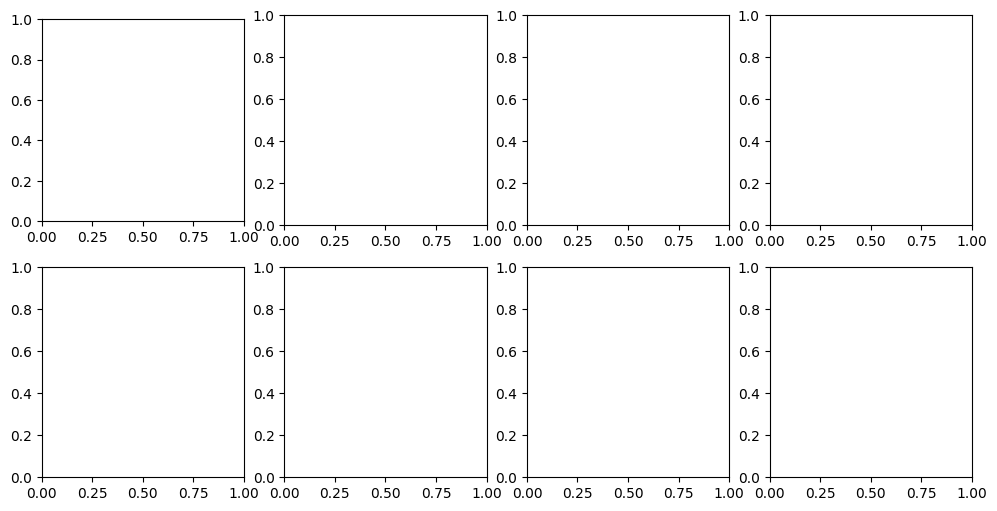

In [28]:
from dotenv import load_dotenv

load_dotenv()
ACCESS_KEY = os.getenv('ACCESS_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')


def load_central_slice(patient_id, bucket='ct-scan-project', prefix='manifest-1748043659198/LIDC-IDRI'):
    s3 = boto3.client(
        's3',
        aws_access_key_id=ACCESS_KEY,
        aws_secret_access_key=SECRET_KEY,
        region_name='us-east-2'
    )
    folder_prefix = f'{prefix}/{patient_id}'
    response = s3.list_objects_v2(Bucket=bucket, Prefix=folder_prefix)

    files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith('.dcm')]
    if not files:
        return
    else:
        slices = []
        for fp in files:
            ds = pydicom.dcmread(fp)
            slices.append((ds.InstanceNumber, ds.pixel_array.astype(np.float32)))
        slices = [s for _, s in sorted(slices, key=lambda x: x[0])]
        vol = np.stack([s for _, s in slices], axis=0)
        img = vol[len(vol)//2]
        # normalize to [0,1]
        img = (img - img.min())/(img.max()-img.min())
        return img

# show 4 positives and 4 negatives
fig, axes = plt.subplots(2,4, figsize=(12,6))
pos_ids = ann[ann['diagnosis']==0]['patientid'].values[:4]
neg_ids = ann[ann['diagnosis'].isin([1,2,3])]['patientid'].values[:4]
print('NEGGAR', neg_ids)

for ax, pid in zip(axes[0], pos_ids):
    ax.imshow(load_central_slice(pid), cmap='gray')
    ax.set_title(f'Patient {pid}\nLabel=1')
    ax.axis('off')

for ax, nid in zip(axes[1], neg_ids):
    ax.imshow(load_central_slice(nid), cmap='gray')
    ax.set_title(f'Patient {nid}\nLabel=0')
    ax.axis('off')

## 5. Pixel-Intensity Histogram

In [1]:
# gather intensities from a small sample to avoid huge memory usage
samples = pos_ids.tolist() + neg_ids.tolist()
pixels = []
for pid in tqdm(samples):
    img = load_central_slice(pid)
    pixels.extend(img.flatten())
    
plt.figure(figsize=(8,4))
plt.hist(pixels, bins=50, alpha=0.7)
plt.title('Intensity Distribution (Sample)')
plt.xlabel('Normalized intensity')
plt.ylabel('Frequency')

NameError: name 'pos_ids' is not defined

## 6. Quick Training Sanity Check 

In [ ]:
import torch
from torch.utils.data import DataLoader
from src.dataloader import LIDCDataset
from src.model import NoduleClassifier

# small one-batch test
ds = LIDCDataset('../data/LIDC-IDRI', '../data/annotations.csv', transforms=None)
dl = DataLoader(ds, batch_size=4, shuffle=True)
imgs, labels = next(iter(dl))
model = NoduleClassifier(pretrained=False)
out = model(imgs)
print('Output shape:', out.shape)  # should be [4,2]